# Logs

In [13]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pickle

# Paths
base = "/triumvirate/home/alexarol/breast_cancer_analysis"

tn_csv = (f"{base}/results/recode_outputs/tn/TN_RECODE_sig_genes_cellsxgenes_forWGCNA.csv")
sig_genes_path = (f"{base}/results/recode_outputs/tn/TN_RECODE_sig_genes_atleast2.txt")

sample_label = "TN"          
n_cells_expected = 7561       

# Helper functions

In [3]:
def add_mito_qc(adata: sc.AnnData) -> sc.AnnData:
    """Flag mitochondrial genes and compute QC metrics."""
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt"],
        percent_top=None,
        log1p=False,
        inplace=True,
    )
    return adata


def summarize_qc(adata, sample_name="sample"):
    """Print QC summary: median, IQR, whiskers for violin metrics."""
    obs = adata.obs
    metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    print(f"QC summary for {sample_name}")
    print("-" * 60)
    for m in metrics:
        s = obs[m]
        desc = s.describe()
        q1, q3 = desc["25%"], desc["75%"]
        iqr = q3 - q1
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr
        print(
            f"{m}: median={desc['50%']:.1f}, IQR=[{q1:.1f}, {q3:.1f}], "
            f"whiskers≈[{lower_whisker:.1f}, {upper_whisker:.1f}], "
            f"min={desc['min']:.1f}, max={desc['max']:.1f}"
        )
    print()


def suggest_qc_thresholds(adata, fixed_min_genes=200, max_mt_cap=20.0):
    """Suggest data-driven QC thresholds from violin distributions."""
    obs = adata.obs
    
    def whiskers(x):
        desc = x.describe()
        q1, q3 = desc["25%"], desc["75%"]
        iqr = q3 - q1
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    low_w_genes, high_w_genes = whiskers(obs["n_genes_by_counts"])
    min_genes = max(fixed_min_genes, low_w_genes, 0)
    max_genes = high_w_genes
    
    _, high_w_counts = whiskers(obs["total_counts"])
    max_counts = high_w_counts
    
    _, high_w_mt = whiskers(obs["pct_counts_mt"])
    max_pct_mt = min(high_w_mt, max_mt_cap)
    
    thresholds = {
        "min_genes": float(min_genes),
        "max_genes": float(max_genes),
        "max_counts": float(max_counts),
        "max_pct_mt": float(max_pct_mt),
    }
    
    print("Suggested QC thresholds (from violins):")
    for k, v in thresholds.items():
        print(f"  {k}: {v:.2f}")
    print()
    
    return thresholds

# Loading inital data

In [14]:
# Load significant genes
sig_genes = pd.read_csv(sig_genes_path)["gene"].astype(str).tolist()

# Read header to get columns
all_cols = pd.read_csv(tn_csv, nrows=0).columns.astype(str).tolist()
cell_col = all_cols[0]
expr_cols = all_cols[1:]

# Intersect with sig genes
genes = pd.Index(sig_genes).intersection(expr_cols)

# Early check: did we get any genes?
if len(genes) == 0:
    raise ValueError(
        f"No overlap between sig_genes ({len(sig_genes)}) and TN columns "
        f"({len(expr_cols)}). Check gene naming / capitalization."
    )

# Cap at 10000 for initial QC/visualization
max_genes = 10000
if len(genes) > max_genes:
    genes = genes[:max_genes]

usecols = [cell_col] + genes.tolist()

print(f"Loading {sample_label} data with {len(genes)} genes for QC")
df = pd.read_csv(
    tn_csv,
    usecols=usecols,
    dtype={cell_col: str}
)

# Expression matrix
expr = df.iloc[:, 1:].copy()
expr.index = df.iloc[:, 0].astype(str)

# Optional: make sure everything is numeric
expr = expr.apply(pd.to_numeric, errors="coerce")

adata_tn = sc.AnnData(X=expr.values)
adata_tn.obs_names = expr.index
adata_tn.var_names = expr.columns.astype(str)

print(f"Initial shape ({sample_label}): {adata_tn.shape}")

Loading TN data with 10000 genes for QC
Initial shape (TN): (7561, 10000)


# Flaging mitochondrial and ribosomal genes

In [15]:
# Mitochondrial
adata_tn = add_mito_qc(adata_tn)

# Ribosomal (same KEGG set)
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_symbols = ribo_genes[0].values
adata_tn.var["ribo"] = adata_tn.var_names.isin(ribo_symbols)

# Compute QC metrics
sc.pp.calculate_qc_metrics(
    adata_tn,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

print(adata_tn)
adata_tn.obs.head()
adata_tn.var.head()

AnnData object with n_obs × n_vars = 7561 × 10000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'


mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
A1BG      False               1177     0.237799              84.433276   
A1BG-AS1  False                131     0.018384              98.267425   
A2M       False                914     0.253406              87.911652   
A2ML1     False                255     0.042719              96.627430   
A4GALT    False               1728     0.296522              77.145880   

          total_counts   ribo  
A1BG              1798  False  
A1BG-AS1           139  False  
A2M               1916  False  
A2ML1              323  False  
A4GALT            2242  False

#  Filtering genes with min_cells ≥ 3 (chunked)

In [16]:
print(f"Genes before filtering ({sample_label}): {adata_tn.n_vars}")

gene_counts = np.zeros(adata_tn.n_vars, dtype=np.int64)
chunksize = 2000
n_chunks = int(np.ceil(adata_tn.n_obs / chunksize))

print(f"Counting gene presence across {adata_tn.n_obs} cells in {n_chunks} chunks")
for i in range(n_chunks):
    start = i * chunksize
    end = min((i + 1) * chunksize, adata_tn.n_obs)
    
    chunk = adata_tn.X[start:end, :]
    
    # Handle dense vs sparse
    if hasattr(chunk, "toarray"):  # sparse matrix
        chunk = chunk.toarray()
    
    # Count how many cells have expression > 0 per gene
    gene_counts += (chunk > 0).sum(axis=0)
    
    if (i + 1) % 10 == 0 or i == n_chunks - 1:
        print(f"  Processed chunk {i+1}/{n_chunks}")

# Keep genes expressed in at least 3 cells
genes_keep_mask = gene_counts >= 3
print(f"Genes passing min_cells=3: {genes_keep_mask.sum()} / {adata_tn.n_vars}")

adata_tn = adata_tn[:, genes_keep_mask]
print(f"Genes after filtering ({sample_label}): {adata_tn.n_vars}")

Genes before filtering (TN): 10000
Counting gene presence across 7561 cells in 4 chunks
  Processed chunk 4/4
Genes passing min_cells=3: 9216 / 10000
Genes after filtering (TN): 9216


# Pre‑filtering QC violins, thresholds, apply QC

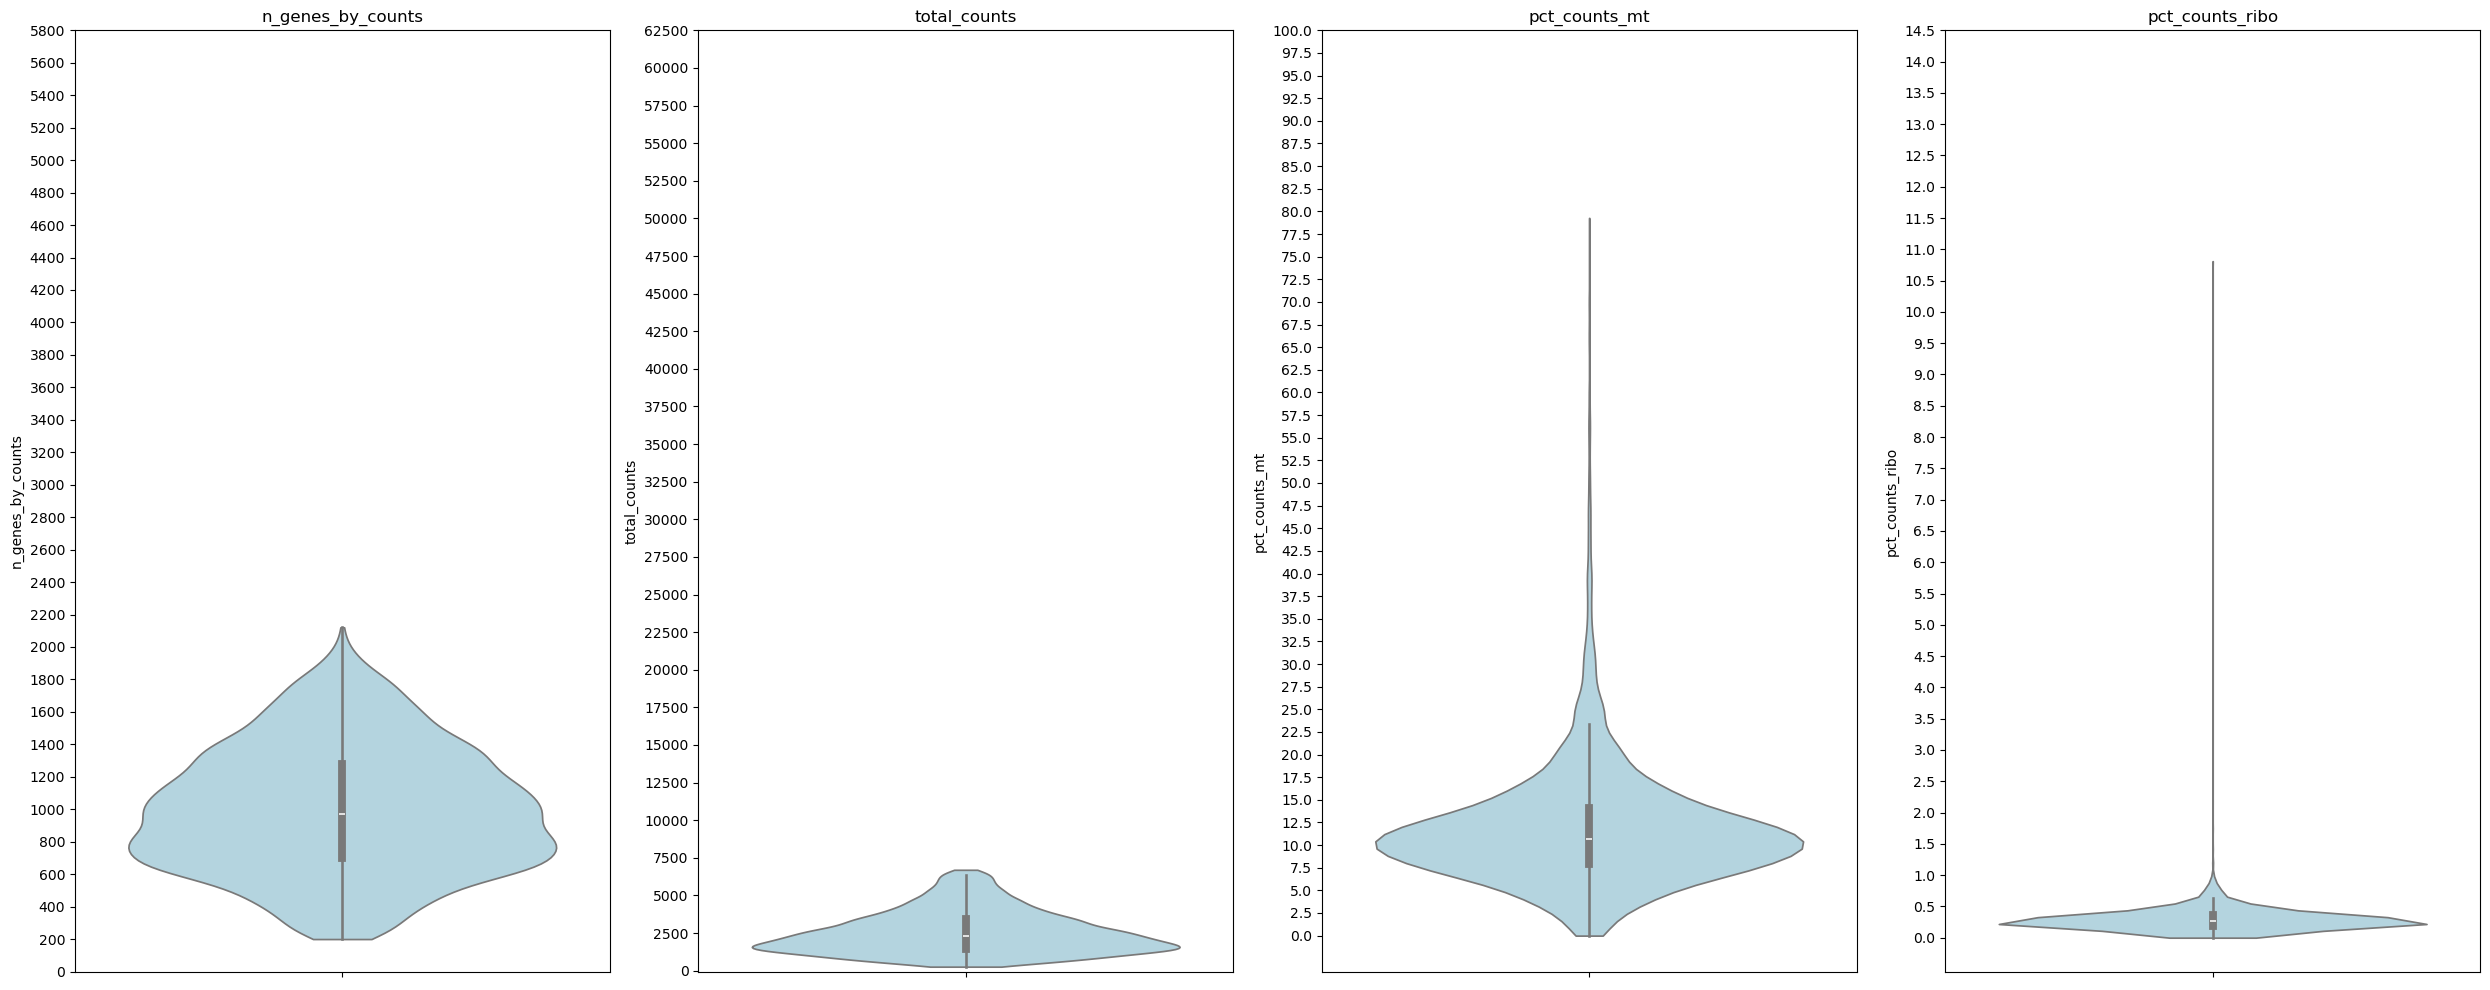

QC summary for Triple_Negative
------------------------------------------------------------
n_genes_by_counts: median=970.0, IQR=[700.0, 1278.0], whiskers≈[-167.0, 2145.0], min=200.0, max=2121.0
total_counts: median=2278.0, IQR=[1470.0, 3441.0], whiskers≈[-1486.5, 6397.5], min=265.0, max=6703.0
pct_counts_mt: median=10.7, IQR=[7.9, 14.1], whiskers≈[-1.4, 23.4], min=0.0, max=79.3
pct_counts_ribo: median=0.3, IQR=[0.2, 0.4], whiskers≈[-0.1, 0.6], min=0.0, max=10.8

Suggested QC thresholds (from violins):
  min_genes: 200.00
  max_genes: 2145.00
  max_counts: 6397.50
  max_pct_mt: 20.00

Cells before QC (TN): 6669
Cells after QC (TN): 6601
6601 cells remain after QC (TN)


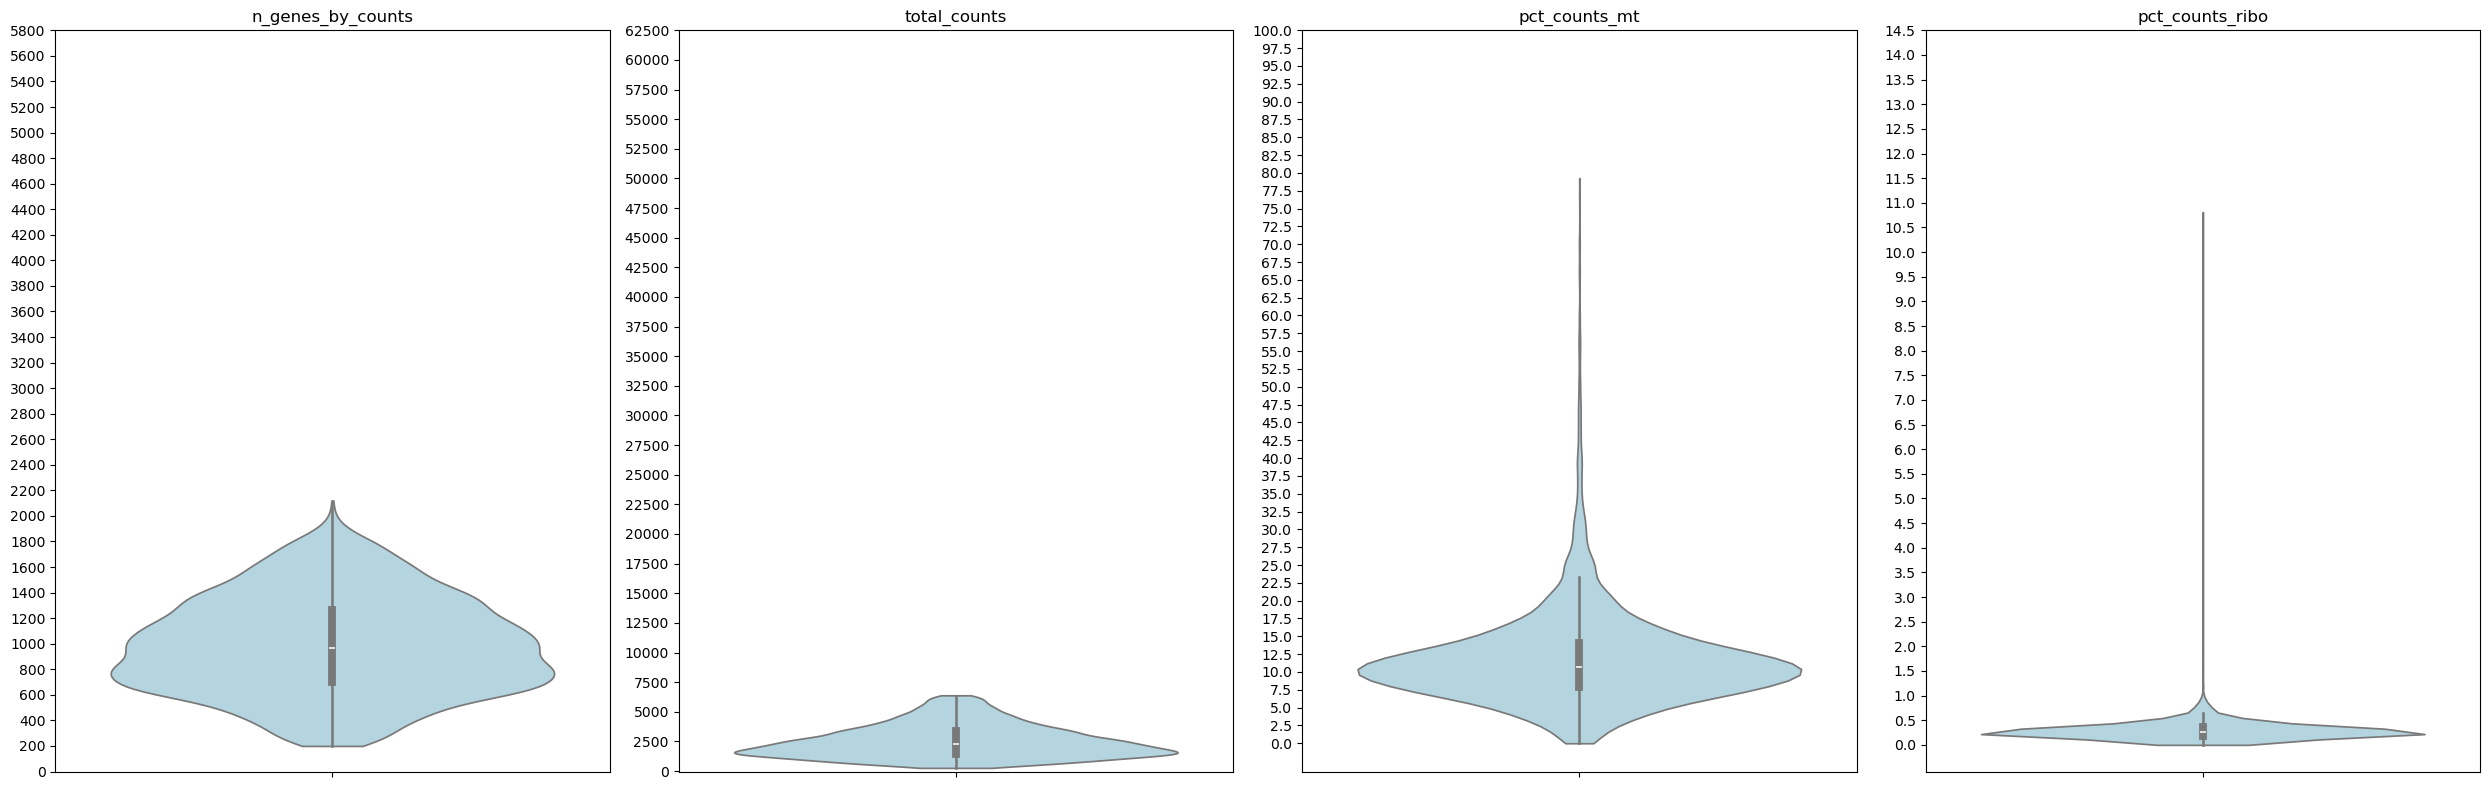

In [19]:
metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

# Pre-QC violins
fig, axes = plt.subplots(1, 4, figsize=(25, 10))

for i, m in enumerate(metrics):
    sns.violinplot(
        y=adata_tn.obs[m],
        ax=axes[i],
        inner="box",
        cut=0,
        color="lightblue",
    )
    axes[i].set_title(m)

axes[0].set_yticks(np.arange(0, 6000, 200))     
axes[1].set_yticks(np.arange(0, 65000, 2500))    
axes[2].set_yticks(np.arange(0, 101, 2.5))       
axes[3].set_yticks(np.arange(0, 15.0, 0.5)) 

plt.tight_layout()
plt.show()

summarize_qc(adata_tn, sample_name="Triple_Negative")
thr_tn = suggest_qc_thresholds(adata_tn)

# Override mito filter if you want same reasoning as HER2
thr_tn["max_pct_mt"] = None

# Apply QC (n_genes + total_counts only)
obs = adata_tn.obs
mask = (
    (obs["n_genes_by_counts"] >= thr_tn["min_genes"]) &
    (obs["n_genes_by_counts"] <= thr_tn["max_genes"]) &
    (obs["total_counts"] <= thr_tn["max_counts"])
)

print(f"Cells before QC ({sample_label}): {adata_tn.n_obs}")
print(f"Cells after QC ({sample_label}): {mask.sum()}")

adata_tn = adata_tn[mask]
print(f"{adata_tn.n_obs} cells remain after QC ({sample_label})")

# Post-QC violins
fig, axes = plt.subplots(1, 4, figsize=(25, 8))

for i, m in enumerate(metrics):
    sns.violinplot(
        y=adata_tn.obs[m],
        ax=axes[i],
        inner="box",
        cut=0,
        color="lightblue",
    )
    axes[i].set_title(m, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

axes[0].set_yticks(np.arange(0, 6000, 200))     
axes[1].set_yticks(np.arange(0, 65000, 2500))    
axes[2].set_yticks(np.arange(0, 101, 2.5))       
axes[3].set_yticks(np.arange(0, 15.0, 0.5)) 

plt.tight_layout()
plt.show()

#  Saving QC‑passed cell IDs

In [20]:
qc_cells = adata_tn.obs_names.to_list()
qc_cells_tn_file = "TN_QC_cells.txt"
pd.Series(qc_cells).to_csv(qc_cells_tn_file, index=False, header=False)
print(f"Saved {len(qc_cells)} QC-passed cell IDs to {qc_cells_tn_file}")

Saved 6601 QC-passed cell IDs to TN_QC_cells.txt


# Chunked normalization (CP10k + log1p)

In [21]:
qc_cells = set(adata_tn.obs_names.astype(str).tolist())
genes_keep = adata_tn.var_names.astype(str).tolist()

chunk_iter = pd.read_csv(tn_csv, index_col=0, chunksize=1000)

out_path = "TN_QC_CP10k_log1p_forWGCNA.csv"
first_chunk = True

print("Starting chunked normalization for TN")
for i, chunk in enumerate(chunk_iter):
    if i % 50 == 0:
        print(f"  Processing chunk {i}")
    
    chunk.index = chunk.index.astype(str)
    
    # Keep only QC-passed cells
    chunk = chunk.loc[chunk.index.intersection(qc_cells)]
    if chunk.empty:
        continue
    
    # Keep only the global gene set
    cols = [g for g in genes_keep if g in chunk.columns]
    chunk = chunk[cols]
    
    # CP10k normalize
    lib_size = chunk.sum(axis=1)
    chunk_norm = chunk.div(lib_size, axis=0) * 1e4
    
    # log1p
    chunk_log = np.log1p(chunk_norm)
    
    # Write/append
    if first_chunk:
        chunk_log.to_csv(out_path)
        first_chunk = False
    else:
        chunk_log.to_csv(out_path, mode="a", header=False)

print(f"Normalized matrix saved to {out_path}")

Starting chunked normalization for TN
  Processing chunk 0


/triumvirate/apps/.scratch/alexarol/ipykernel_285919/3627315397.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_285919/3627315397.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_285919/3627315397.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):


Normalized matrix saved to TN_QC_CP10k_log1p_forWGCNA.csv


# Verifying normalized matrix dimensions

In [22]:
n_cells = 0
n_genes = None

chunk_iter = pd.read_csv(out_path, index_col=0, chunksize=500, low_memory=False)

for ch in chunk_iter:
    n_cells += ch.shape[0]
    if n_genes is None:
        n_genes = ch.shape[1]

print(f"Normalized matrix ({sample_label}): {n_cells} cells × {n_genes} genes")

Normalized matrix (TN): 6601 cells × 9216 genes


# Computing HVGs (3000 genes, chunked variance)

In [23]:
file_path = out_path
chunksize = 500

n_genes_hvg = None
gene_sum = None
gene_sq_sum = None
n_cells_hvg = 0

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing per-gene mean and variance (TN)")
for ch in chunk_iter:
    ch_values = ch.values.astype(float)
    if n_genes_hvg is None:
        n_genes_hvg = ch_values.shape[1]
        gene_sum = np.zeros(n_genes_hvg, dtype=np.float64)
        gene_sq_sum = np.zeros(n_genes_hvg, dtype=np.float64)
    
    n = ch_values.shape[0]
    n_cells_hvg += n
    gene_sum += ch_values.sum(axis=0)
    gene_sq_sum += (ch_values ** 2).sum(axis=0)

gene_mean = gene_sum / n_cells_hvg
gene_var = gene_sq_sum / n_cells_hvg - gene_mean**2

# Get gene names
chunk_iter = pd.read_csv(file_path, index_col=0, nrows=1)
gene_names = chunk_iter.columns.to_numpy()

hvg_stats = pd.DataFrame({
    "gene": gene_names,
    "mean": gene_mean,
    "var": gene_var
})

# Sort by variance and pick top 3000
hvg_stats_sorted = hvg_stats.sort_values("var", ascending=False)
top_n = 3000
hvg_3000 = hvg_stats_sorted.head(top_n)["gene"].tolist()

print(f"{len(hvg_3000)} HVGs selected for TN")

# Save HVG list
hvg_file = "TN_HVG_3000.txt"
pd.Series(hvg_3000).to_csv(hvg_file, index=False, header=False)
print(f"HVG list saved to {hvg_file}")

Computing per-gene mean and variance (TN)
3000 HVGs selected for TN
HVG list saved to TN_HVG_3000.txt


# Building HVG AnnData for clustering

In [24]:
hvg_3000 = pd.read_csv("TN_HVG_3000.txt", header=None)[0].astype(str).tolist()

file_path = out_path
chunksize = 1000

cell_ids = []
rows = []

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Building HVG AnnData (TN)")
for ch in chunk_iter:
    ch = ch[hvg_3000]
    cell_ids.extend(ch.index.astype(str).tolist())
    rows.append(ch.values.astype(np.float32))

X = np.vstack(rows)

adata_tn_hvg = sc.AnnData(X=X)
adata_tn_hvg.obs_names = cell_ids
adata_tn_hvg.var_names = hvg_3000

# Bring over obs metadata from adata_tn
adata_tn_hvg.obs = adata_tn.obs.loc[adata_tn_hvg.obs_names].copy()

print(f"HVG AnnData shape ({sample_label}): {adata_tn_hvg.shape}")
print(adata_tn_hvg.obs.head())

Building HVG AnnData (TN)
HVG AnnData shape (TN): (6601, 3000)
    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
2                1147          2794              278       9.949893   
4                1531          4998              591      11.824730   
20               1737          6153              746      12.124167   
23               1074          2271              231      10.171731   
26               1489          4783              155       3.240644   

    total_counts_ribo  pct_counts_ribo  
2                   9         0.322119  
4                  15         0.300120  
20                 11         0.178775  
23                  5         0.220167  
26                 13         0.271796  


# Quick gene correlation heatmap (top 50 variable HVGs)

/triumvirate/apps/.scratch/alexarol/ipykernel_285919/3077203663.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  subset = pd.read_csv(file_path, index_col=0, nrows=5000)


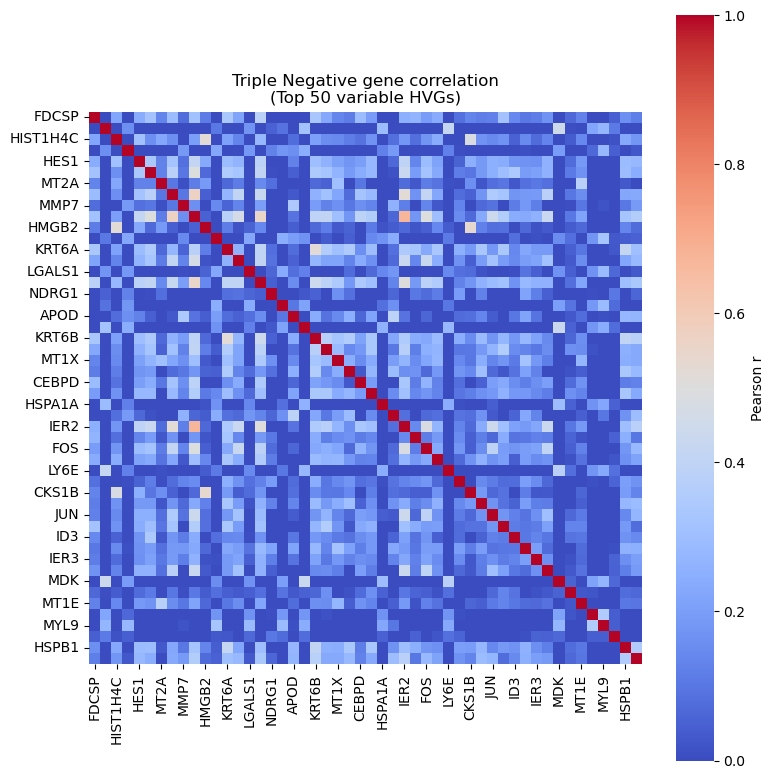

In [25]:
file_path = out_path
hvg_3000 = pd.read_csv("TN_HVG_3000.txt", header=None)[0].astype(str).tolist()

# Read a manageable subset of cells to estimate variability (e.g. first 5000)
subset = pd.read_csv(file_path, index_col=0, nrows=5000)
subset = subset[hvg_3000]  # keep HVGs only

# Pick top 50 most variable HVGs within this subset
gene_var = subset.var(axis=0)
top_n = 50
top_genes = gene_var.sort_values(ascending=False).head(top_n).index.tolist()

# Compute full correlation among these 50 genes across ALL cells (chunked)
chunksize = 2000
corr_data = {g: [] for g in top_genes}

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)
for ch in chunk_iter:
    ch = ch[top_genes]
    for g in top_genes:
        corr_data[g].extend(ch[g].values.tolist())

corr_df = pd.DataFrame(corr_data)
corr_mat = corr_df.corr(method="pearson")

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_mat,
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("Triple Negative gene correlation\n(Top 50 variable HVGs)")
plt.tight_layout()
plt.show()

# Scale, PCA, neighbors, UMAP, Leiden

Scaling genes (TN)
Computing PCA (TN)


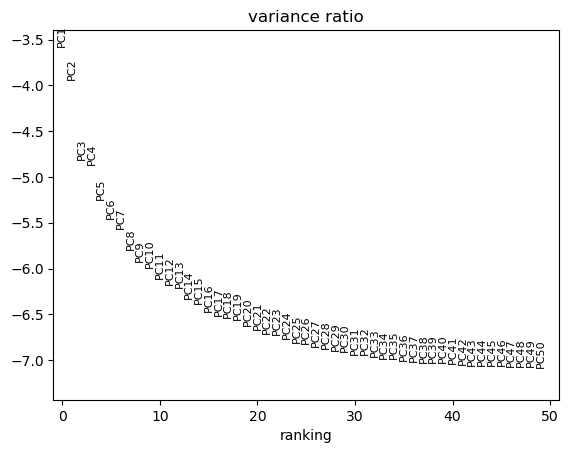

Building neighbor graph (30 PCs)
Computing UMAP (TN)
Leiden clustering (resolution=0.5)


/triumvirate/apps/.scratch/alexarol/ipykernel_285919/1844993985.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_tn_hvg, resolution=0.5)


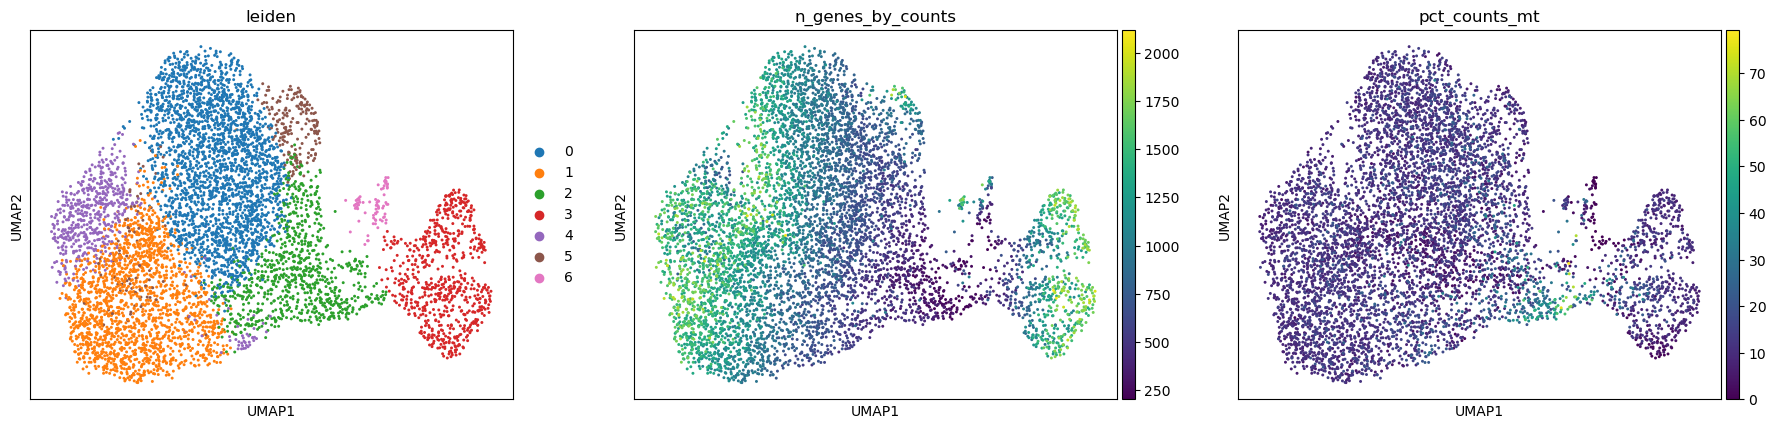

In [26]:
print("Scaling genes (TN)")
sc.pp.scale(adata_tn_hvg, max_value=10)

print("Computing PCA (TN)")
sc.tl.pca(adata_tn_hvg, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_tn_hvg, log=True, n_pcs=50)

print("Building neighbor graph (30 PCs)")
sc.pp.neighbors(adata_tn_hvg, n_pcs=30)

print("Computing UMAP (TN)")
sc.tl.umap(adata_tn_hvg)

print("Leiden clustering (resolution=0.5)")
sc.tl.leiden(adata_tn_hvg, resolution=0.5)

sc.pl.umap(adata_tn_hvg, color=["leiden", "n_genes_by_counts", "pct_counts_mt"])

# Flaging high‑mito clusters (data‑driven)

Global pct_mt summary (TN):
count    6601.000000
mean       11.846521
std         6.933568
min         0.000000
25%         7.882146
50%        10.707965
75%        14.076246
max        79.276673
Name: pct_counts_mt, dtype: float64
Upper whisker ≈ 23.4%

Mean pct_counts_mt per cluster (TN):
leiden
6     9.099838
5    10.371823
3    10.464839
4    10.699788
1    11.136823
0    11.369040
2    17.412623
Name: pct_counts_mt, dtype: float64

High-mt clusters (mean > upper whisker ≈ 23.4%): []


/triumvirate/apps/.scratch/alexarol/ipykernel_285919/874397914.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_mt = adata_tn_hvg.obs.groupby("leiden")["pct_counts_mt"].mean().sort_values()


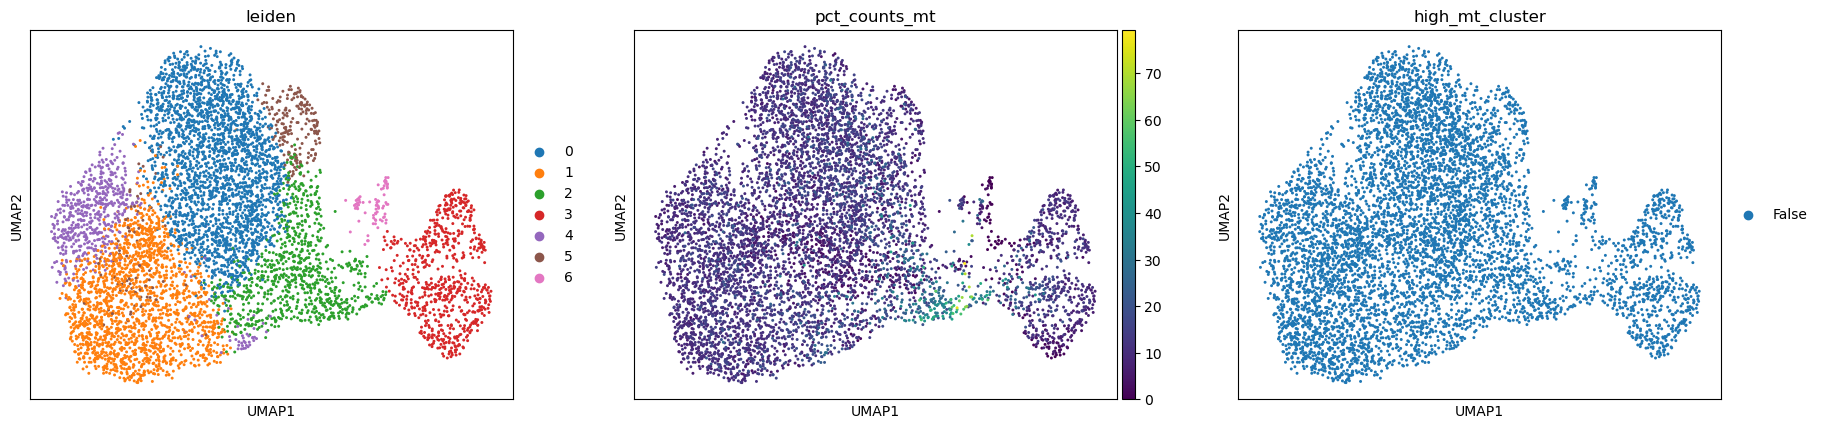

In [27]:
# Global stats
desc = adata_tn_hvg.obs["pct_counts_mt"].describe()
q1, q3 = desc["25%"], desc["75%"]
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr

print("Global pct_mt summary (TN):")
print(desc)
print(f"Upper whisker ≈ {upper_whisker:.1f}%")

cluster_mt = adata_tn_hvg.obs.groupby("leiden")["pct_counts_mt"].mean().sort_values()
print("\nMean pct_counts_mt per cluster (TN):")
print(cluster_mt)

# Flag clusters whose mean is above the upper whisker
high_mt_clusters = cluster_mt[cluster_mt > upper_whisker].index.tolist()
print(f"\nHigh-mt clusters (mean > upper whisker ≈ {upper_whisker:.1f}%): {high_mt_clusters}")

adata_tn_hvg.obs["high_mt_cluster"] = adata_tn_hvg.obs["leiden"].isin(high_mt_clusters)

sc.pl.umap(adata_tn_hvg, color=["leiden", "pct_counts_mt", "high_mt_cluster"])

# Saving frozen AnnData

In [28]:
frozen_file = "adata_TN_HVG_UMAP_leiden_frozen.h5ad"
adata_tn_hvg.write_h5ad(frozen_file)
print(f"Saved frozen AnnData to {frozen_file}")

Saved frozen AnnData to adata_TN_HVG_UMAP_leiden_frozen.h5ad


# Marker genes per cluster (top 20)

In [29]:
print("Computing marker genes per cluster (TN)")
sc.tl.rank_genes_groups(adata_tn_hvg, groupby="leiden", method="wilcoxon")

# Extract top 20 per cluster
n_top = 20
marker_dict = {}

for cluster in adata_tn_hvg.obs["leiden"].cat.categories:
    markers = sc.get.rank_genes_groups_df(adata_tn_hvg, group=cluster).head(n_top)
    marker_dict[cluster] = markers["names"].tolist()
    print(f"Cluster {cluster}: {markers['names'].tolist()[:5]}...")  # show first 5

# Save markers
marker_file = "TN_cluster_markers_top20.pkl"
with open(marker_file, "wb") as f:
    pickle.dump(marker_dict, f)

print(f"Saved cluster markers to {marker_file}")

Computing marker genes per cluster (TN)
Cluster 0: ['CST3', 'JUNB', 'LGALS3', 'NACA', 'COMMD6']...
Cluster 1: ['HIST1H4C', 'HMGB2', 'CKS1B', 'ASF1B', 'H2AFZ']...
Cluster 2: ['MALAT1', 'MT-CO1', 'NEAT1', 'MT-CO3', 'MT-ND3']...
Cluster 3: ['IFI27', 'MDK', 'LY6E', 'COX6C', 'MIF']...
Cluster 4: ['CDC20', 'ARL6IP1', 'CCNB2', 'CKS2', 'CENPF']...
Cluster 5: ['KRT81', 'FAU', 'CRYAB', 'AZGP1', 'LGALS3']...
Cluster 6: ['MUCL1', 'AZGP1', 'MIF', 'EEF2', 'GPX4']...
Saved cluster markers to TN_cluster_markers_top20.pkl


/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnase

# Chunked gene‑gene correlation (3000 × 3000)

In [30]:
file_path = out_path
hvg_3000 = pd.read_csv("TN_HVG_3000.txt", header=None)[0].astype(str).tolist()

chunksize = 1000
gene_sum = None
gene_sq_sum = None
n_cells_corr = 0

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing gene-gene correlation (TN, pass 1: means)")
for ch in chunk_iter:
    ch = ch[hvg_3000]
    ch_values = ch.values.astype(np.float64)
    
    if gene_sum is None:
        n_genes_corr = ch_values.shape[1]
        gene_sum = np.zeros(n_genes_corr, dtype=np.float64)
        gene_sq_sum = np.zeros(n_genes_corr, dtype=np.float64)
    
    n = ch_values.shape[0]
    n_cells_corr += n
    gene_sum += ch_values.sum(axis=0)
    gene_sq_sum += (ch_values ** 2).sum(axis=0)

gene_mean_corr = gene_sum / n_cells_corr
gene_std = np.sqrt(gene_sq_sum / n_cells_corr - gene_mean_corr**2)

print(f"Pass 1 complete (TN): {n_cells_corr} cells processed")

# Pass 2: covariance matrix
cov_matrix = np.zeros((n_genes_corr, n_genes_corr), dtype=np.float64)

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing gene-gene correlation (TN, pass 2: covariance)")
for i, ch in enumerate(chunk_iter):
    if i % 20 == 0:
        print(f"  Chunk {i}")
    
    ch = ch[hvg_3000]
    ch_values = ch.values.astype(np.float64)
    
    # Center
    ch_centered = ch_values - gene_mean_corr
    
    # Accumulate covariance
    cov_matrix += ch_centered.T @ ch_centered

# Normalize to correlation
cov_matrix /= n_cells_corr
corr_matrix = cov_matrix / np.outer(gene_std, gene_std)

# Clip to [-1, 1] for numerical stability
corr_matrix = np.clip(corr_matrix, -1, 1)

print(f"Correlation matrix shape (TN): {corr_matrix.shape}")
print(f"Min correlation (TN): {corr_matrix.min():.3f}")
print(f"Max correlation (TN): {corr_matrix.max():.3f}")

corr_file = "TN_HVG_correlation_matrix.npy"
np.save(corr_file, corr_matrix)
print(f"Saved correlation matrix to {corr_file}")

Computing gene-gene correlation (TN, pass 1: means)
Pass 1 complete (TN): 6601 cells processed
Computing gene-gene correlation (TN, pass 2: covariance)
  Chunk 0
Correlation matrix shape (TN): (3000, 3000)
Min correlation (TN): -0.417
Max correlation (TN): 1.000
Saved correlation matrix to TN_HVG_correlation_matrix.npy


# Alternative heatmap: top connected HVGs

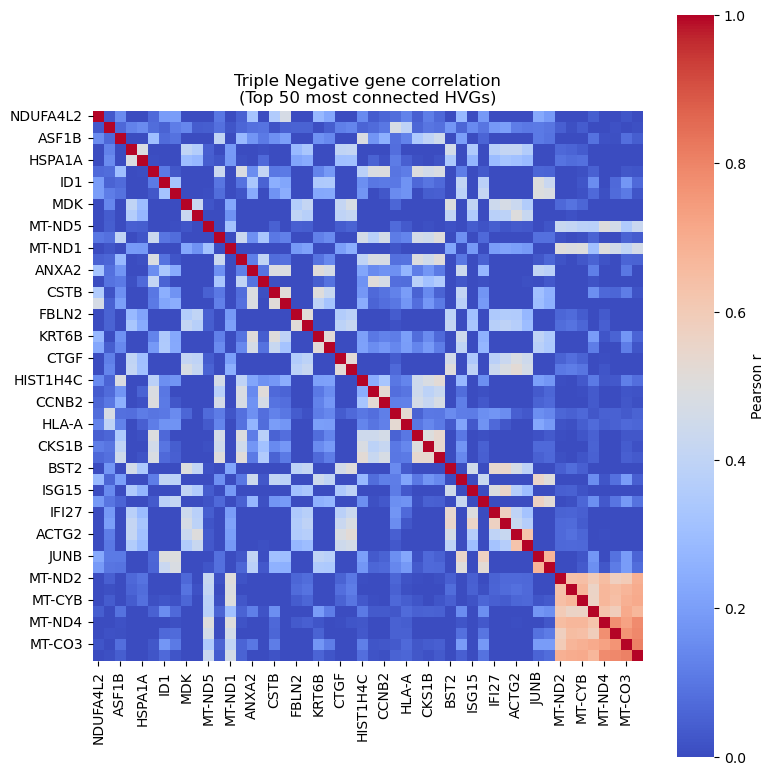

In [31]:
corr_matrix = np.load("TN_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("TN_HVG_3000.txt", header=None)[0].astype(str).tolist()

# For each gene, compute max(|r|) to any other gene
max_abs_r = np.max(np.abs(corr_matrix - np.eye(corr_matrix.shape[0])), axis=1)
top_n = 50
top_idx = np.argsort(max_abs_r)[-top_n:]
top_genes = [hvg_3000[i] for i in top_idx]

sub_corr = corr_matrix[np.ix_(top_idx, top_idx)]
corr_df = pd.DataFrame(sub_corr, index=top_genes, columns=top_genes)

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("Triple Negative gene correlation\n(Top 50 most connected HVGs)")
plt.tight_layout()
plt.show()

# Build full co‑expression network (keep complete network)

In [32]:
corr_matrix = np.load("TN_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("TN_HVG_3000.txt", header=None)[0].astype(str).tolist()

threshold = 0.35  # same as HER2 script

# Build edge list
edges = []
n_genes_net = len(hvg_3000)

print(f"Building TN network with |r| >= {threshold}")
for i in range(n_genes_net):
    for j in range(i + 1, n_genes_net):
        r = corr_matrix[i, j]
        if abs(r) >= threshold:
            edges.append((hvg_3000[i], hvg_3000[j], {"weight": r}))

print(f"Found {len(edges)} edges (TN)")

# Create network
G_tn = nx.Graph()
G_tn.add_nodes_from(hvg_3000)
G_tn.add_edges_from(edges)

print(f"TN network: {G_tn.number_of_nodes()} nodes, {G_tn.number_of_edges()} edges")

# Save network
network_file = "TN_gene_network_r035.graphml"
nx.write_graphml(G_tn, network_file)
print(f"Saved TN network to {network_file}")

Building TN network with |r| >= 0.35
Found 523 edges (TN)
TN network: 3000 nodes, 523 edges
Saved TN network to TN_gene_network_r035.graphml


# Visualize hub‑gene subnetwork

Top hubs (gene, degree) TN: [('HMGB2', 31), ('IFI6', 26), ('BST2', 25), ('DDIT4', 24), ('ACTG2', 24), ('HRCT1', 24), ('KRT6B', 23), ('MDK', 23), ('BIRC5', 23), ('CENPF', 23)]
Edges in H (TN): 295


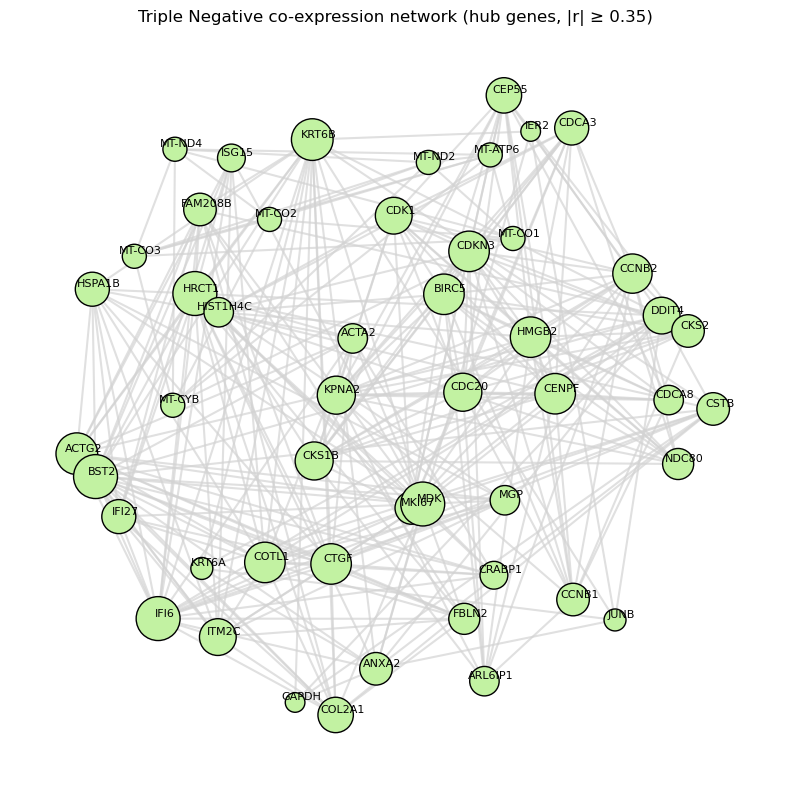

In [37]:
# Pick hub genes: top 50 by degree
N = 50
degree_dict = dict(G_tn.degree())
top_hubs = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:N]
hub_genes = [g for g, d in top_hubs]

H = G_tn.subgraph(hub_genes).copy()

print("Top hubs (gene, degree) TN:", top_hubs[:10])
print("Edges in H (TN):", H.number_of_edges())

# Layout
pos = nx.spring_layout(H, seed=0, k=1.3)

# Node sizes proportional to degree
deg_H = dict(H.degree())
node_sizes = np.array([deg_H[g] for g in H.nodes()]) * 50

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(H, pos, width=1.5, edge_color="lightgrey", alpha=0.7)
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color="#c2f2a2", edgecolors="black")

for node, (x, y) in pos.items():
    plt.text(
        x + 0.02, y, node,
        fontsize=8,
        ha="center", va="bottom"
    )

plt.title("Triple Negative co-expression network (hub genes, |r| ≥ 0.35)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Detect modules (Louvain)

In [34]:
print("Detecting modules with Louvain (TN)")
modules_tn = nx.community.louvain_communities(G_tn, seed=42)

print(f"Found {len(modules_tn)} modules (TN)")

# Create gene-to-module mapping
gene_to_module_tn = {}
for module_id, gene_set in enumerate(modules_tn):
    for gene in gene_set:
        gene_to_module_tn[gene] = module_id

# Module sizes
module_sizes = [len(m) for m in modules_tn]
print(f"Module sizes (TN): min={min(module_sizes)}, max={max(module_sizes)}, median={np.median(module_sizes):.0f}")

# Save modules
with open("TN_gene_modules.pkl", "wb") as f:
    pickle.dump(modules_tn, f)

with open("TN_gene_to_module.pkl", "wb") as f:
    pickle.dump(gene_to_module_tn, f)

print("Saved TN modules to TN_gene_modules.pkl and TN_gene_to_module.pkl")

Detecting modules with Louvain (TN)
Found 2865 modules (TN)
Module sizes (TN): min=1, max=42, median=1
Saved TN modules to TN_gene_modules.pkl and TN_gene_to_module.pkl


# Largest connected component plot (full network view)

TN largest component: 81 nodes, 284 edges


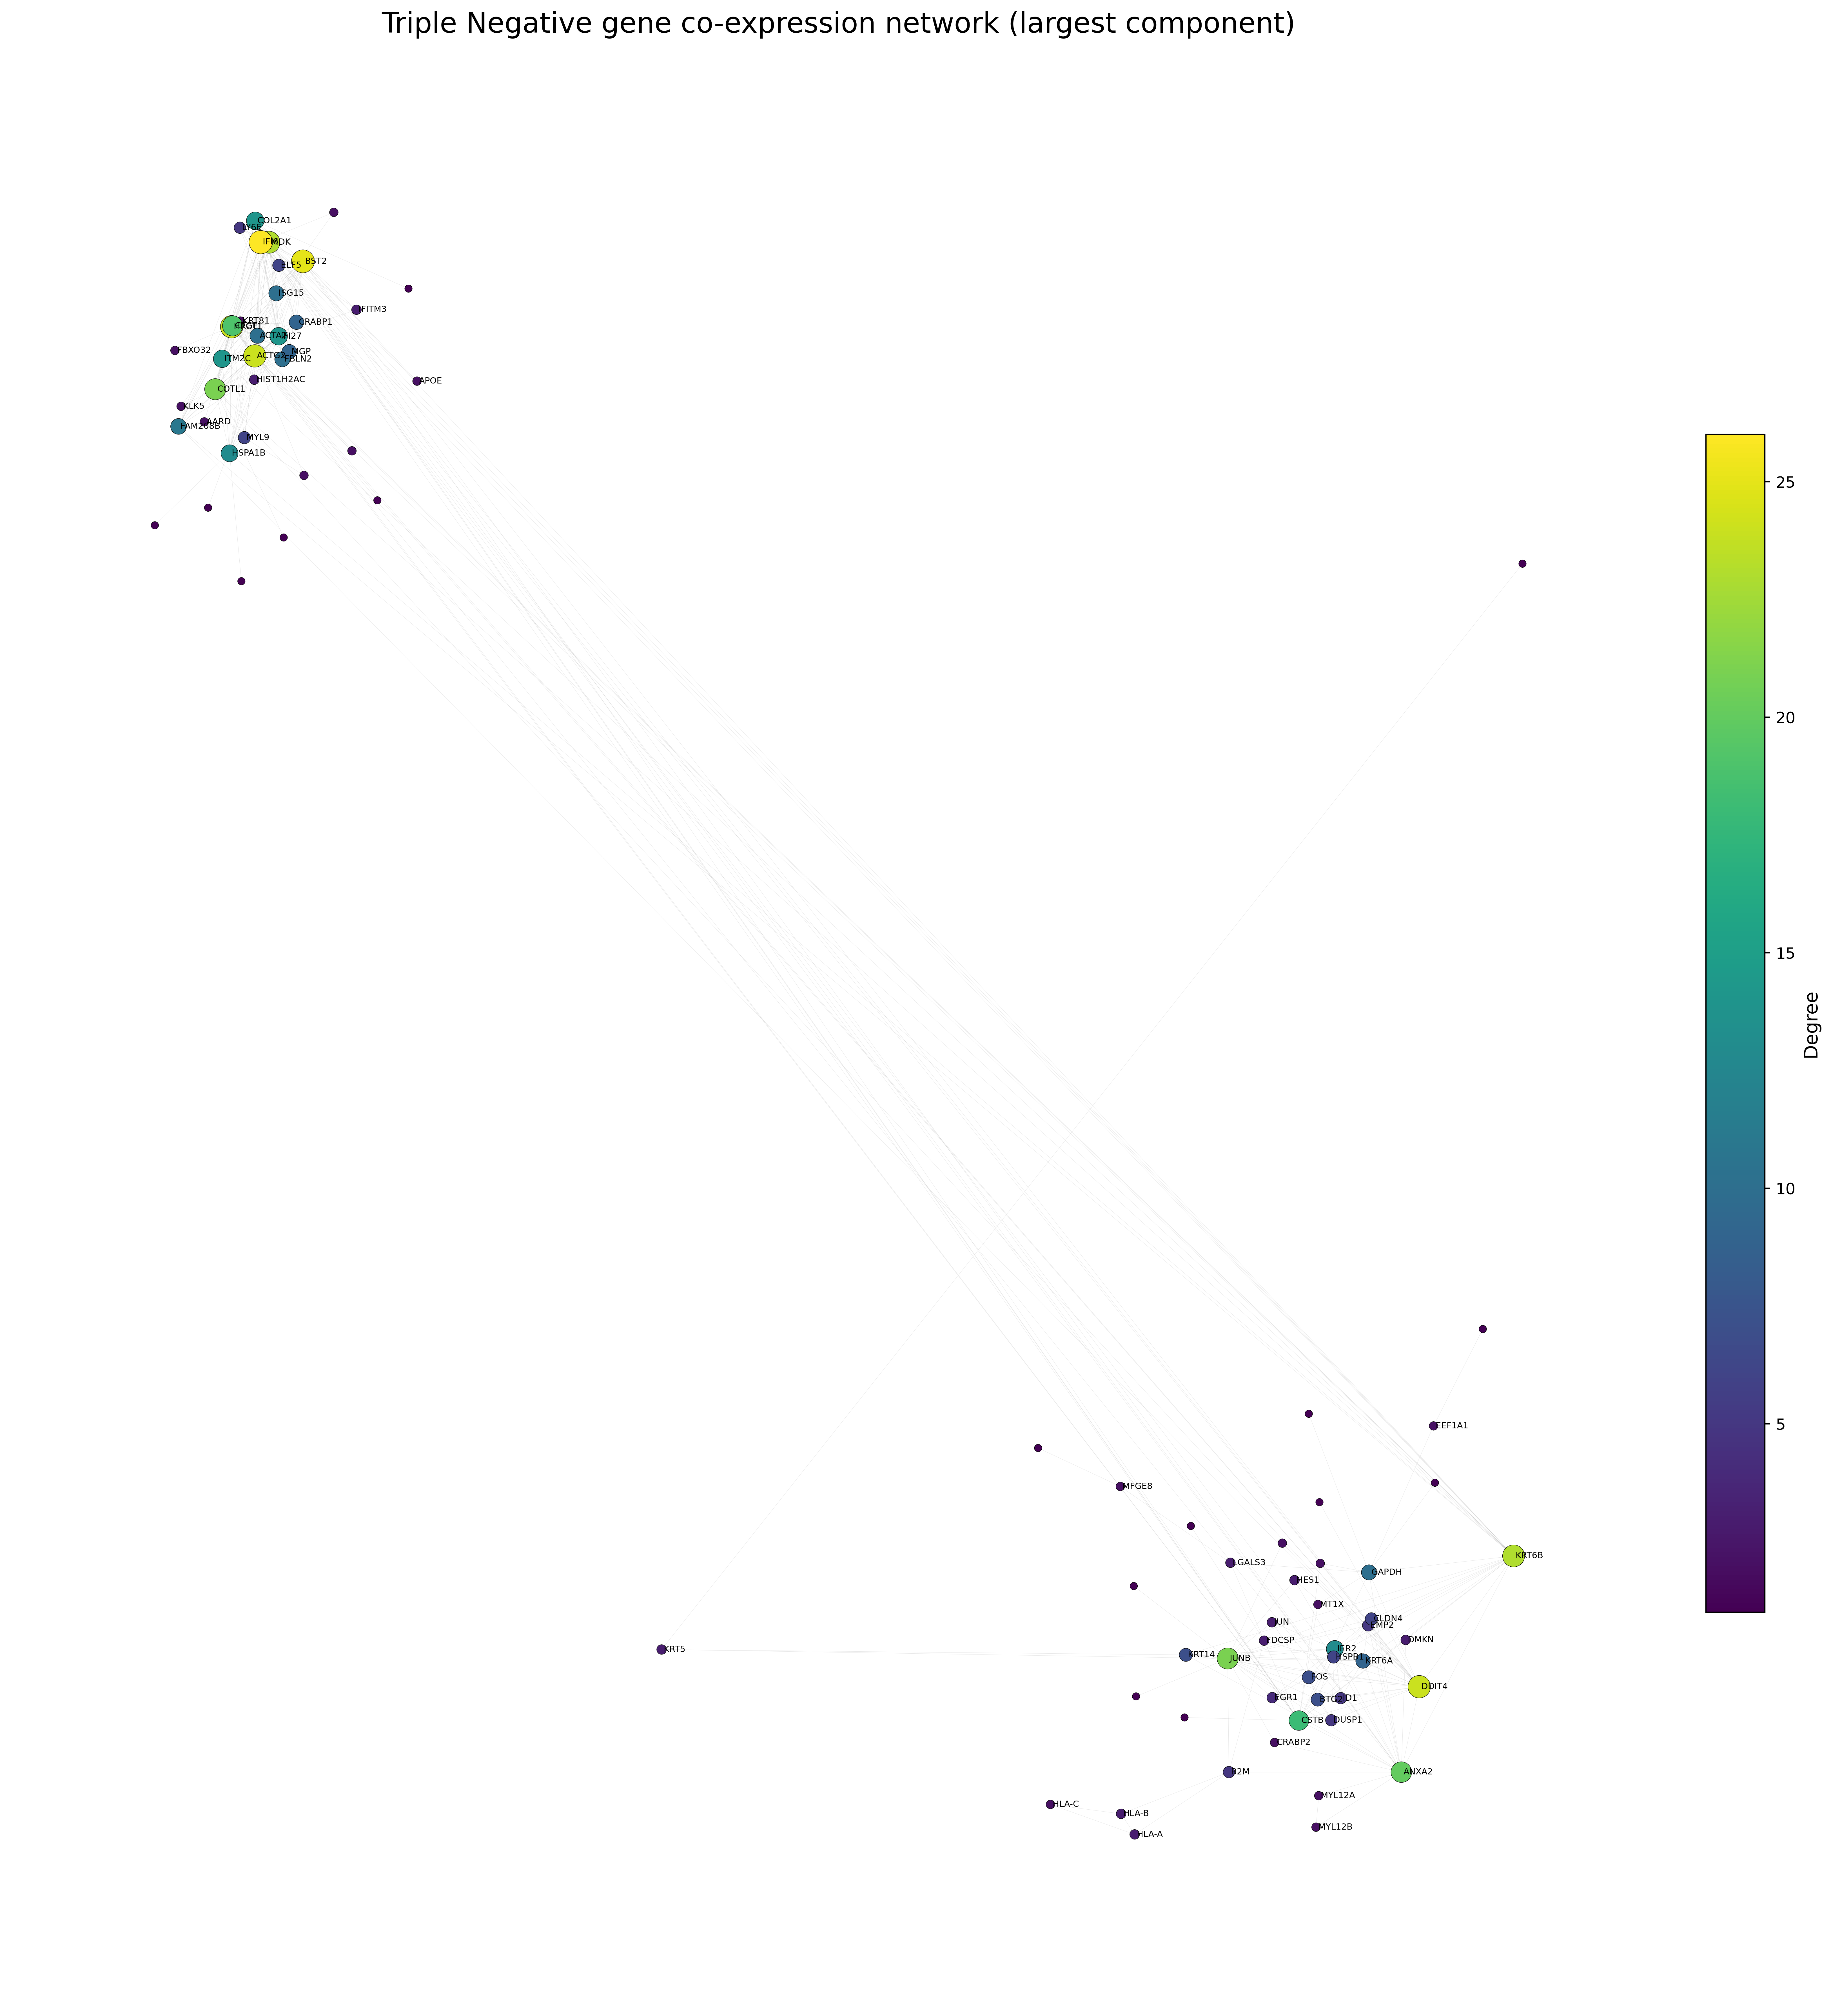

In [35]:
components = list(nx.connected_components(G_tn))
largest = max(components, key=len)
G_tn_lcc = G_tn.subgraph(largest).copy()

print("TN largest component:", G_tn_lcc.number_of_nodes(), "nodes,", G_tn_lcc.number_of_edges(), "edges")

# Layout
pos = nx.spring_layout(G_tn_lcc, seed=0, k=0.35, iterations=200)

# Degree
deg_lcc = dict(G_tn_lcc.degree())
deg_array = np.array([deg_lcc[g] for g in G_tn_lcc.nodes()], dtype=float)

# Node sizes
node_sizes = 15 + deg_array * 8

plt.figure(figsize=(18, 18), dpi=400)

# Edges
nx.draw_networkx_edges(
    G_tn_lcc, pos,
    width=0.2,
    edge_color="grey",
    alpha=0.18,
)

# Nodes
nodes = nx.draw_networkx_nodes(
    G_tn_lcc, pos,
    node_size=node_sizes,
    node_color=deg_array,
    cmap="viridis",
    edgecolors="black",
    linewidths=0.25,
)

# Colorbar
cbar = plt.colorbar(nodes, shrink=0.6, pad=0.02)
cbar.set_label("Degree", fontsize=12)

# Label only top K hubs
K = 60
top_hubs_lcc = sorted(deg_lcc.items(), key=lambda x: x[1], reverse=True)[:K]
label_genes = set(g for g, d in top_hubs_lcc)

for gene, (x, y) in pos.items():
    if gene in label_genes:
        plt.text(
            x + 0.003, y, gene,
            fontsize=5.5,
            ha="left", va="center",
            color="black",
        )

plt.title("Triple Negative gene co-expression network (largest component)", fontsize=18)
plt.axis("off")
plt.tight_layout()

# Save high-resolution version
plt.savefig(
    "TN_network_largest_component_pubready.png",
    dpi=600,
    bbox_inches="tight"
)

plt.show()

In [36]:
module_hubs_tn = {}

for module_id, gene_set in enumerate(modules_tn):
    subgraph = G_tn.subgraph(gene_set)
    degrees = dict(subgraph.degree())
    
    # Sort by degree (desc)
    sorted_genes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    top_10 = [gene for gene, deg in sorted_genes[:10]]
    
    module_hubs_tn[module_id] = top_10
    print(f"TN Module {module_id} ({len(gene_set)} genes): {top_10[:5]}...")  # show first 5

# Save hubs
with open("TN_module_hubs_top10.pkl", "wb") as f:
    pickle.dump(module_hubs_tn, f)

print("Saved TN module hubs to TN_module_hubs_top10.pkl")
print("\n" + "="*60)
print("Triple Negative analysis complete!")
print("="*60)
print(f"QC-passed cells (TN): {adata_tn_hvg.n_obs}")
print(f"HVGs (TN): {len(hvg_3000)}")
print(f"Leiden clusters (TN): {len(adata_tn_hvg.obs['leiden'].cat.categories)}")
print(f"Network edges (TN): {G_tn.number_of_edges()}")
print(f"Modules (TN): {len(modules_tn)}")
print("\nOutput files:")
print("  - TN_QC_cells.txt")
print("  - TN_QC_CP10k_log1p_forWGCNA.csv")
print("  - TN_HVG_3000.txt")
print("  - adata_TN_HVG_UMAP_leiden_frozen.h5ad")
print("  - TN_cluster_markers_top20.pkl")
print("  - TN_HVG_correlation_matrix.npy")
print("  - TN_gene_network_r035.graphml")
print("  - TN_gene_modules.pkl")
print("  - TN_gene_to_module.pkl")
print("  - TN_module_hubs_top10.pkl")


TN Module 0 (1 genes): ['KRT19']...
TN Module 1 (2 genes): ['MT2A', 'MT1E']...
TN Module 2 (1 genes): ['MMP7']...
TN Module 3 (1 genes): ['CRYAB']...
TN Module 4 (1 genes): ['LGALS1']...
TN Module 5 (38 genes): ['JUNB', 'DDIT4', 'ANXA2', 'IER2', 'CSTB']...
TN Module 6 (3 genes): ['IGFBP3', 'ERO1A', 'NDRG1']...
TN Module 7 (1 genes): ['LY6D']...
TN Module 8 (1 genes): ['ANXA1']...
TN Module 9 (1 genes): ['IER3']...
TN Module 10 (1 genes): ['ID3']...
TN Module 11 (1 genes): ['CALML5']...
TN Module 12 (1 genes): ['ATP1B1']...
TN Module 13 (1 genes): ['CLDN3']...
TN Module 14 (1 genes): ['KRT17']...
TN Module 15 (1 genes): ['GPRC5A']...
TN Module 16 (1 genes): ['CSTA']...
TN Module 17 (1 genes): ['FGFBP2']...
TN Module 18 (1 genes): ['CYR61']...
TN Module 19 (1 genes): ['KRT8']...
TN Module 20 (1 genes): ['KRT7']...
TN Module 21 (1 genes): ['ELF3']...
TN Module 22 (1 genes): ['CHI3L1']...
TN Module 23 (3 genes): ['HLA-DRA', 'CD74', 'HLA-DRB1']...
TN Module 24 (1 genes): ['LCN2']...
TN Modu